# Momento de Retroalimentación: Módulo 2 Análisis y Reporte sobre el desempeño del modelo. (Portafolio Análisis)

#### *Diego Alberto Baños Lopez*
#### *A01275100*

## Introducción

En este reporte, analizamos el desempeño de un modelo de regresión lineal entrenado con datos de ventas de helados en función de la temperatura. Las ventas de helados y la temperatura están estrechamente relacionadas, ya que es probable que las ventas aumenten con temperaturas más altas.


## Parte 1: Importacion de librerias y leer el dataset
Para ello se requiere que primeramente leamos las librerias necesarias y una vez realizado ello se guarda el dataset como data

In [76]:
#  Importamos las siguientes librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# El dataset a usar se llama Ice Cream Revenue
# Los datos se pueden obtener de https://www.kaggle.com/datasets/vinicius150987/ice-cream-revenue
data = pd.read_csv("./IceCreamData.csv")
data.head(10)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
5,14.352514,367.940744
6,13.707780,308.894518
7,30.833985,696.716640
8,0.976870,55.390338
9,31.669465,737.800824


Cantidad de muestras:  500
Número de caracterías:  2
Rango de valores de salida (Revenue):  (10.0, 1000.0)


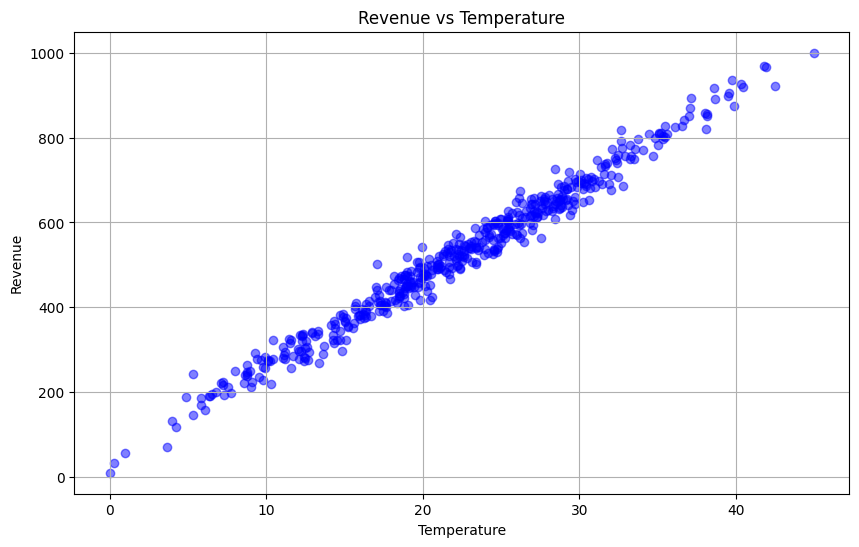

In [77]:
#Descripcion breve del dataset
num_samples = data.shape[0]
num_features = data.shape[1]
output_range = (data['Revenue'].min(), data['Revenue'].max())

print("Cantidad de muestras: ", num_samples)
print("Número de caracterías: ", num_features)
print("Rango de valores de salida (Revenue): ", output_range)

#Graficamos los datos
plt.figure(figsize=(10, 6))
plt.scatter(data['Temperature'], data['Revenue'], color='blue', alpha=0.5)
plt.title('Revenue vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


## Parte 2: Division de datos

Aqui realizamos la division de datos en subsets, uno de entrenamiento (train), otro de pruebas (test) y otro de validación (val)

In [78]:
# Dividimos en dos el dataset
# Variable Independiente
X = data[["Temperature"]]
# Variable dependiente
y = data["Revenue"]

# División a subsets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Aqui usando la libreria de scikit learn se entrena el modelo de regresión lineal
model = LinearRegression(fit_intercept=False, copy_X=False, positive=True)
model.fit(X_train, y_train)

LinearRegression(copy_X=False, fit_intercept=False, positive=True)

## Parte 3: Desempeño y validación del modelo

Primero sacaremos el rendimiento de este primer modelo, luego calcularemos el sesgo que tenga, la varianza y si comote overfitting, underfitting o ninguno de los dos

In [79]:
# Predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)
# Metricas del rendimiento (MSE y R^2)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
val_r2 = r2_score(y_val, val_predictions)

# Guardamos las metricas como dataframe
metrics_df = pd.DataFrame(
    {
        "Metricas": [
            "MSE (train)",
            "R^2 (train)",
            "MSE (test)",
            "R^2 (test)",
            "MSE (val)",
            "R^2 (val)",
        ],
        "Valores": [train_mse, train_r2, test_mse, test_r2, val_mse, val_r2],
    }
)
# Mostramos las metricas generadas
metrics_df

,Metricas,Valores
0,MSE (train),868.753196
1,R^2 (train),0.973563
2,MSE (test),1028.919039
3,R^2 (test),0.959984
4,MSE (val),654.920060
5,R^2 (val),0.977014


In [80]:
# Funcion para determinar el sesgo
def determinar_sesgo(train_r2, val_r2):
    if train_r2 < 0.7 and val_r2 < 0.7:
        return "alto"
    elif train_r2 > 0.9 and val_r2 > 0.9:
        return "bajo"
    else:
        return "medio"

# Funcion para determinar el grado de varianza
def determinar_varianza(train_r2, val_r2):
    if train_r2 > 0.9 and (val_r2 < 0.7 or abs(train_r2 - val_r2) > 0.2):
        return "alto"
    elif train_r2 > 0.9 and val_r2 > 0.9:
        return "bajo"
    else:
        return "medio"

#Funcion para determinar el nivel de ajuste, o sea overfitting, underfitting o ninguno
def determinar_ajuste(bias, variance):
    if bias == "alto" and variance == "bajo":
        return "underfitting"
    elif bias == "bajo" and variance == "alto":
        return "overfitting"
    else:
        return "ajuste adecuado"

# Funcion para hacer el diagnostico
def diagnostico(train_r2, val_r2):
    sesgo = determinar_sesgo(train_r2, val_r2)
    varianza = determinar_varianza(train_r2, val_r2)
    ajuste = determinar_ajuste(sesgo, varianza)
    
    # Crear un DataFrame con una fila para el diagnóstico
    data = {
        "Nivel de sesgo": [sesgo],
        "Nivel de varianza": [varianza],
        "Nivel de ajuste": [ajuste]
    }
    
    df_diagnostico = pd.DataFrame(data)
    return df_diagnostico

#Realizamos el diagnostico
diagnostico(train_r2, val_r2)

,Nivel de sesgo,Nivel de varianza,Nivel de ajuste
0,bajo,bajo,ajuste adecuado


Como se puede observar en los resultados el modelo actual ya se ajusta de manera adecuada a los datos, en donde no se observan que haya un sesgo importante, en donde el grado de variabilidad es bajo y no hay un overfitting o underfitting con el modelo actual, sin aplicar regularización

## Parte 4: Tecnicas de regularizacion

Aqui intentaremos regularizar para ver si hay mejoras respecto al modelo de regresión lineal, usaremos la regresión de cresta (Ridge) para este caso en particular.
La regularización Ridge agrega un término de penalización al error del modelo para evitar que los coeficientes se vuelvan demasiado grandes, lo que puede ayudar a prevenir el overfitting, no obstante no hay ningun tipo de overfitting observado en el modelo de regresión, sin embargo se implementara de todas formas para poder ver como mejora le modelo, como se habia comentado anteriormente.

In [81]:
# Definición del modelo Ridge y búsqueda de cuadrícula para el parámetro de regularización alpha
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100]}
ridge_regressor = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

# Mejor parámetro y MSE
best_alpha = ridge_regressor.best_params_['alpha']
best_mse = ridge_regressor.best_score_

print("Mejor Alpha: ", best_alpha)
print("Mejor MSE: ", best_mse)

Mejor Alpha:  1e-15
Mejor MSE:  -633.052087263211


In [82]:
# Predicciones con el modelo Ridge
ridge_test_predictions = ridge_regressor.predict(X_test)
ridge_val_predictions = ridge_regressor.predict(X_val)

# Métricas del rendimiento (MSE y R^2) para el modelo Ridge
ridge_test_mse = mean_squared_error(y_test, ridge_test_predictions)
ridge_val_mse = mean_squared_error(y_val, ridge_val_predictions)

ridge_test_r2 = r2_score(y_test, ridge_test_predictions)
ridge_val_r2 = r2_score(y_val, ridge_val_predictions)

ridge_metrics_df = pd.DataFrame(
    {
        "Metricas": [
            "MSE (test) Ridge",
            "R^2 (test) Ridge",
            "MSE (val) Ridge",
            "R^2 (val) Ridge",
        ],
        "Valores": [ridge_test_mse, ridge_test_r2, ridge_val_mse, ridge_val_r2],
    }
)

ridge_metrics_df

,Metricas,Valores
0,MSE (test) Ridge,711.898211
1,R^2 (test) Ridge,0.972313
2,MSE (val) Ridge,525.210236
3,R^2 (val) Ridge,0.981566


In [83]:
combined_metrics = pd.concat([metrics_df, ridge_metrics_df], axis=1, keys=['Modelo 1', 'Modelo 2'])
combined_metrics

Modelo 1                       Modelo 2            
      Metricas      Valores          Metricas     Valores
0  MSE (train)   868.753196  MSE (test) Ridge  711.898211
1  R^2 (train)     0.973563  R^2 (test) Ridge    0.972313
2   MSE (test)  1028.919039   MSE (val) Ridge  525.210236
3   R^2 (test)     0.959984   R^2 (val) Ridge    0.981566
4    MSE (val)   654.920060               NaN         NaN
5    R^2 (val)     0.977014               NaN         NaN

Los resultados muestran que pese a que hay mejoras dentro de lo que seria el segundo modelo (Ridge), el primero al no mostrar problemas de ajuste, de sesgo o de varianza, hacen que estas mejoras no sean muy dramaticas, o sea que sean muy pequeñas con respecto al primer modelo, no obstante es importante denotar que en casos de que los analisis muestren un problema con el ajuste como un overfittng, el segundo modelo podria ser mejor opción para manejar este tipo de situaciones y tener un mejor rendimiento en la modelación de datos